In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 217.8MB 63kB/s 
     |████████████████████████████████| 204kB 54.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=a590e189dbe33a08972172c5b8739125c4ada38bebc35689909b2d4a3cd98da5
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [0]:
# create the context
conf = SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '6G')
        .set('spark.driver.memory', '45G')
        .set('spark.driver.maxResultSize', '10G'))
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Parse Data

1. `data.txt` contains the dataset which has 4601 rows and 58 columns. Each row is a document represented as a 58 dimensional vector of features. Each component in the vector represents the importance of a word in the document. 

2. `c1.txt` contains k initial cluster centroids. These centroids were chosen by selecting k = 10 random points from the input data. 

3. `c2.txt` contains initial cluster centroids which are as far apart as possible, using Eu- clidean distance as the distance metric.

In [0]:
def read_data(line):
    splitted_line = line[0].split(' ')
    return np.array([float(x) for x in splitted_line])

data = spark.read.text('data.txt').rdd.map(lambda line: read_data(line))
c1 = np.loadtxt('c1.txt', delimiter = ' ')
c2 = np.loadtxt('c2.txt', delimiter = ' ')

## (a) Exploring initialization strategies with Euclidean distance [10 pts]

In [0]:
def closest_centroid(p, centroids): # Euclidean distance
    dis = []
    for centroid in centroids:
        dis.append(np.sum((p-centroid)**2))
    return (np.argmin(dis), (1, np.amin(dis), p)) # return (min_idx, (ct=1, min_err, coordinates)

def get_new_centroid(c):
    idx =  c[0]
    count, error_sum, coordinate_sum = c[1]
    return (idx, error_sum, coordinate_sum/count)

In [0]:
iters = 20

centroids = c1.copy()
error_history_c1 = []

for iter in range(iters):
    closest_centroids = data.map(lambda p: closest_centroid(p, centroids))
    clusters = closest_centroids.reduceByKey(lambda p1, p2: (p1[0]+p2[0], p1[1]+p2[1], p1[2]+p2[2]))
    new_centroids = clusters.map(lambda c: get_new_centroid(c)).collect()

    total_error = 0
    for idx, error, new_centroid in new_centroids:
        total_error += error
        centroids[idx] = new_centroid

    error_history_c1.append(total_error)

centroids = c2.copy()
error_history_c2 = []

for iter in range(iters):
    closest_centroids = data.map(lambda p: closest_centroid(p, centroids))
    clusters = closest_centroids.reduceByKey(lambda p1, p2: (p1[0]+p2[0], p1[1]+p2[1], p1[2]+p2[2]))
    new_centroids = clusters.map(lambda c: get_new_centroid(c)).collect()

    total_error = 0
    for idx, error, new_centroid in new_centroids:
        total_error += error
        centroids[idx] = new_centroid

    error_history_c2.append(total_error)

1. Using the Euclidean distance (refer to Equation 1) as the distance measure, compute the cost function $\phi(i)$ (refer to Equation 2) for every iteration i. This means that, for your first iteration, you’ll be computing the cost function using the initial centroids located in one of the two text files. Run the k-means on data.txt using `c1.txt` and `c2.txt`. Generate a graph where you plot the cost function $\phi(i)$ as a function of the number of iterations $i=1\cdots20$ for `c1.txt` and also for `c2.txt`. You may use a single plot or two different plots, whichever you think best answers the theoretical questions we’re asking you about.

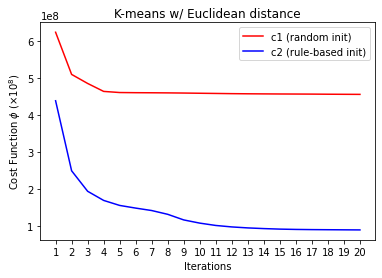

In [13]:
%matplotlib inline

plt.figure()
plt.plot(list(range(1,21)), np.array(error_history_c1), label ='c1', c='red')
plt.plot(list(range(1,21)), np.array(error_history_c2), label ='c2', c='blue')
plt.xticks(list(range(1, 21, 1)))
plt.xlabel('Iterations')
plt.ylabel('Cost Function ' + r'$\phi$ ' + r'($\times 10^8$)')
plt.title('K-means w/ Euclidean distance')
plt.legend(['c1 (random init)', 'c2 (rule-based init)'])

2. What is the percentage change in cost after 10 iterations of the K-Means algorithm when the cluster centroids are initialized using `c1.tx`t vs. `c2.txt` and the distance metric being used is Euclidean distance? Is random initialization of k-means using c1.txt better than initialization using `c2.txt` in terms of cost $\phi(i)$? Explain your reasoning.

In [14]:
c1_percentage_change = (error_history_c1[0]-error_history_c1[10])/error_history_c1[0]
c2_percentage_change = (error_history_c2[0]-error_history_c2[10])/error_history_c2[0]

print('Percentage change in cost after 10 iterations(c1.txt): {:.3f}'.format(c1_percentage_change))
print('Percentage change in cost after 10 iterations(c2.txt): {:.3f}'.format(c2_percentage_change))

Percentage change in cost after 10 iterations(c1.txt): 0.265
Percentage change in cost after 10 iterations(c2.txt): 0.767


## (b) Exploring initialization strategies with Manhattan distance [10 pts]

In [0]:
def closest_centroid(p, centroids): # Manhattan distance
    dis = []
    for centroid in centroids:
        dis.append(np.sum(np.abs(p-centroid)))
    return (np.argmin(dis), (1, np.amin(dis), p)) # return (min_idx, (ct=1, min_err, coordinates)

def get_new_centroid(c):
    idx =  c[0]
    count, error_sum, flat_coordinate_list = c[1]
    coordinate_list = np.reshape(flat_coordinate_list, (count,-1))
    median = np.median(coordinate_list, axis=0)
    return (idx, error_sum, median)

In [0]:
iters = 20

centroids = c1.copy()
error_history_c1 = []

for iter in range(iters):
    closest_centroids = data.map(lambda p: closest_centroid(p, centroids))
    clusters = closest_centroids.reduceByKey(lambda p1, p2: (p1[0]+p2[0], p1[1]+p2[1], np.concatenate((p1[2], p2[2]), axis=None)))
    new_centroids = clusters.map(lambda c: get_new_centroid(c)).collect()

    total_error = 0
    for idx, error, new_centroid in new_centroids:
        total_error += error
        centroids[idx] = new_centroid

    error_history_c1.append(total_error)

centroids = c2.copy()
error_history_c2 = []

for iter in range(iters):
    closest_centroids = data.map(lambda p: closest_centroid(p, centroids))
    clusters = closest_centroids.reduceByKey(lambda p1, p2: (p1[0]+p2[0], p1[1]+p2[1], np.concatenate((p1[2], p2[2]), axis=None)))
    new_centroids = clusters.map(lambda c: get_new_centroid(c)).collect()

    total_error = 0
    for idx, error, new_centroid in new_centroids:
        total_error += error
        centroids[idx] = new_centroid

    error_history_c2.append(total_error)

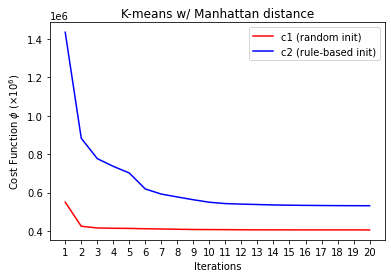

In [17]:
%matplotlib inline

plt.figure()
plt.plot(list(range(1,21)), np.array(error_history_c1), label ='c1', c='red')
plt.plot(list(range(1,21)), np.array(error_history_c2), label ='c2', c='blue')
plt.xticks(list(range(1, 21, 1)))
plt.xlabel('Iterations')
plt.ylabel('Cost Function ' + r'$\phi$ ' + r'($\times 10^6$)')
plt.title('K-medians w/ Manhattan distance')
plt.legend(['c1 (random init)', 'c2 (rule-based init)'])

In [18]:
c1_percentage_change = (error_history_c1[0]-error_history_c1[10])/error_history_c1[0]
c2_percentage_change = (error_history_c2[0]-error_history_c2[10])/error_history_c2[0]

print('Percentage change in cost after 10 iterations(c1.txt): {:.3f}'.format(c1_percentage_change))
print('Percentage change in cost after 10 iterations(c2.txt): {:.3f}'.format(c2_percentage_change))

Percentage change in cost after 10 iterations(c1.txt): 0.260
Percentage change in cost after 10 iterations(c2.txt): 0.621
